### 12. Encoder Decoder Model - ``NMT``

We are going to create a simple NMT model that will translate from spaniszh to english using the encoder decoder achitecture.

In this notebook we are going to look at the basics of NMT in tensorflow 2. We will then have a look on a step futher in by adding the `Attention` mechanism so that we get better results. The basic Encoder Decoder model looks as follows:

![img](https://github.com/edumunozsala/NMT-encoder-decoder-Attention/raw/ca7d7f969a17ddf390f707fceb22d5881d33b1c3/images/encoder_decoder_basic.png)

The seq2seq model consists of two sub-networks, the encoder and the decoder. The encoder, on the left hand, receives sequences from the source language as inputs and produces as a result a compact representation of the input sequence, trying to summarize or condense all its information. Then that output becomes an input or initial state of the decoder, which can also receive another external input. At each time step, the decoder generates an element of its output sequence based on the input received and its current state, as well as updating its own state for the next time step. 

Mention that the input and output sequences are of fixed size but they do not have to match, the length of the input sequence may differ from that of the output sequence.

The critical point of this model is how to get the encoder to provide the most complete and meaningful representation of its input sequence in a single output element to the decoder. Because this vector or state is the only information the decoder will receive from the input to generate the corresponding output. The longer the input, the harder to compress in a single vector.


### Imports

In [1]:
import numpy as np
import typing
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import re, os, time, unicodedata

tf.__version__

'2.6.0'

### Mounting the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/My Drive/NLP Data/seq2seq/spa-en/spa.txt"
os.path.exists(file_path)

True

We will use spainish as our source language and english as our target language in this example.

In [4]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    # Adding the start and end of sequences tokens 
    # w = '<sos> ' + w + ' <eos>'
    return w

### Data and text processing.

We need to remove accents, lower case the sentences and replace everything with space except (a-z, A-Z, ".", "?", "!", ",").

In [6]:
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'

TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM= 1024

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.


In [7]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(file_path, sep="\t", header=None, names=[TARGET_COLUMN, INPUT_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)

# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['ve .', 'vete .', 'vaya .', 'vayase .', 'hola .']
['go . <eos>', 'go . <eos>', 'go . <eos>', 'go . <eos>', 'hi . <eos>']
['<sos> go .', '<sos> go .', '<sos> go .', '<sos> go .', '<sos> hi .']


### Tokenization

* Tokenize the data, to convert the raw text into a sequence of integers. First, we create a Tokenizer object from the keras library and fit it to our text (one tokenizer for the input and another one for the output).
* Extract sequence of integers from the text: we call the ``text_to_sequence`` method of the tokenizer for every input and output text.
* Calculate the maximum length of the input and output sequences.

In [8]:
tokenizer_inputs = Tokenizer(
    num_words = MAX_VOCAB_SIZE, filters=""
)
tokenizer_inputs.fit_on_texts(input_data)
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)

input_max_len = max(len(s) for s in input_sequences)
print('max input length: ', input_max_len)

# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[1000])
print(input_sequences[1000])


max input length:  17
tomas lo intento .
[60, 15, 765, 1]


We can do the same thing to the output sequences.

In [9]:

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)

# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('max target length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])


max target length:  9
tom tried . <eos>
[7, 414, 1, 2]
<sos> tom tried .


### Creating vocabularies

Using the tokenizer we have created previously we can retrieve the vocabularies, one to match word to integer (word2idx) and a second one to match the integer to the corresponding word (idx2word).


In [10]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 7183 unique input tokens.
Found 3669 unique output tokens.


### Padding Sequences
Padding the sentences: we need to pad zeros at the end of the sequences so that all sequences have the same length. Otherwise, we won't be able train the model on batches.

In [11]:
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences,
                               maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)


# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')
print("decoder_targets.shape:", decoder_targets.shape)


encoder_inputs.shape: (20000, 17)
decoder_inputs[0]: [ 3 31  1  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 9)
decoder_targets.shape: (20000, 9)


### Creating a Batch Data Generator

* Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function ``batch_on_slices`` on the input and output sequences.

In [12]:
BUFFER_SIZE = len(input_data)
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

### Encoder Decoder Model.
For a better understanding, we can divide the model in three basic components:

![img](https://github.com/edumunozsala/NMT-encoder-decoder-Attention/raw/ca7d7f969a17ddf390f707fceb22d5881d33b1c3/images/encoder_decoder_RNN.jpeg)

*  **The encoder:** Layers of recurrent units where in each time step, receive a an input token, collects relevant information and produce a hidden state. Depends on the type of RNN, in our example a LSTM, the unit "mixes" the current hidden state and the input and return an output, discarded, and a new hidden state. 

* **The encoder vector:** it is the last hidden state of the encoder and it tries to contain as much of the useful input information as possible to help the decoder get the best results. It is only information from the input that the decoder will get.

* **The decoder:** Layers of recurrent units, i.e. LSTMs, where each unit produces an output at a time step t. The hidden state of the first unit is the encoder vector and the rest of units accept the hidden state from the previous unit. The output is calculated using a **``_softmax_``** function to obtain a probability for every token in the output vocabulary.




### Encoder Class


In [13]:
class Encoder(keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim

    self.embedding = keras.layers.Embedding(
        vocab_size, embedding_dim
    )
    self.lstm = keras.layers.LSTM(hidden_dim,
                                  return_sequences=True,
                                  return_state=True
                                  )
    
  def call(self, input_sequence, states):
    embedded  = self.embedding(input_sequence)
    output, h_0, c_0 = self.lstm(embedded, initial_state= states)
    return output, h_0, c_0 

  def init_states(self, batch_size):
    return(
        tf.zeros([batch_size, self.hidden_dim]),
        tf.zeros([batch_size, self.hidden_dim]),
    )


### Decoder Class

In [14]:
class Decoder(keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Decoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = keras.layers.Embedding(
        vocab_size, embedding_dim
    )
    self.lstm = keras.layers.LSTM(
         hidden_dim, return_sequences=True, return_state=True
    )
    self.out = keras.layers.Dense(vocab_size)

  def call(self, input_sequence, state):
    embedded = self.embedding(input_sequence)
    output, h_0, c_0 = self.lstm(embedded, initial_state=state)
    logits = self.out(output)
    return logits, h_0, c_0

Once our encoder and decoder are defined we can init them and set the initial hidden state. We have included a simple test, calling the encoder and decoder to check they works fine.

In [15]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1

#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
initial_state = encoder.init_states(1)
# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 23, 4, 5, 0, 0]]), initial_state)
print(test_encoder_output[0].shape)




# Create the decoder
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
de_initial_state = test_encoder_output[1:]
# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)
print(test_decoder_output[0].shape)

(1, 6, 1024)
(1, 8, 3670)


### Loss function and metrics

Now we need to define a custom loss function to avoid taking into account the 0 values, padding values, when calculating the loss. And also we have to define a custom accuracy function.


In [16]:
def loss_func(targets, logits):
  crossentropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
  # Mask padding values, they do not have to compute for loss
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64) 
  loss = crossentropy(targets, logits, sample_weight=mask)
  return loss
     

In [17]:
def accuracy_fn(y_true, y_pred):
  # y_pred shape is batch_size, seq length, vocab size
  # y_true shape is batch_size, seq length
  pred_values = keras.backend.cast(keras.backend.argmax(y_pred, axis=-1), dtype='int32')
  correct = keras.backend.cast(keras.backend.equal(y_true, pred_values), dtype='float32')

  # 0 is padding, don't include those
  mask = keras.backend.cast(keras.backend.greater(y_true, 0),
                            dtype='float32')
  n_correct = keras.backend.sum(mask * correct)
  n_total = keras.backend.sum(mask)
  return n_correct / n_total


### Training

As we mentioned before, we are interested in training the network in batches, therefore, we create a function that carries out the training of a batch of the data:

* Call the encoder for the batch input sequence, the output is the encoded vector.
* Set the decoder initial states to the encoded vector
* Call the decoder, taking the right shifted target sequence as input. The output are the logits (the softmax function is applied in the loss function)
* Calculate the loss and accuracy of the batch data
* Update the learnable parameters of the encoder and the decoder
update the optimizer


In [18]:
@tf.function
def train_step(
     input_seq, target_seq_in, target_seq_out,
     en_initial_states, optimizer
  ):
  with tf.GradientTape() as tape:
    # Get the encoder outputs
    en_outputs = encoder(input_seq, en_initial_states)
    # Set the encoder and decoder states
    en_states = de_states = en_outputs[1:]

    # Get the decoder outputs
    de_outputs = decoder(target_seq_in, de_states)
    # Take the actual output
    logits = de_outputs[0]
    # Calculate the loss function
    loss = loss_func(target_seq_out, logits)
    acc = accuracy_fn(target_seq_out, logits)
  
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc

Our train function receives three sequences:

**Input sequence:** array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the input sequence to the encoder.

**target sequence:** array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the target of our model, the output that we want for our model.

**Target input sequence:** array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the input sequence to the decoder because we use Teacher Forcing.


### Oh Teacher Forcing
Teacher forcing is a training method critical to the development of deep learning models in NLP. It is a way for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

In a recurrent network usually the input to a RNN at the time step t is the output of the RNN in the previous time step, t-1. But with teacher forcing we can use the actual output to improve the learning capabilities of the model.

_"Teacher forcing works by using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network. So, in our example, the input to the decoder is the target sequence right-shifted, the target output at time step t is the decoder input at time step t+1."_

When our model output do not vary from what was seen by the model during training, teacher forcing is very effective. But if we need a more "creative" model, where given an input sequence there can be several possible outputs, we should avoid this technique or apply it randomly (only in some random time steps).

Now, we can code the whole training process:


In [19]:
def fit(encoder, decoder, dataset, n_epochs, batch_size,
        optimizer, checkpoint, checkpoint_prefix
        ):
  losses =[]
  accuracies = []
  for e in range(n_epochs):
    start = time.time()
    en_initial_states = encoder.init_states(batch_size)
    for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
      loss, accuracy = train_step(input_seq, target_seq_in,
                                  target_seq_out, 
                                  en_initial_states, optimizer)
      if batch % 100 == 0:
        losses.append(loss)
        accuracies.append(accuracy)
        print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
      
    if (e + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
  return losses, accuracies


We are almost ready, our last step include a call to the main train function and we create a checkpoint object to save our model. Because the training process require a long time to run, every two epochs we save it. Later we can restore it and use it to make predictions.

In [20]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = fit(encoder, decoder,
                         dataset, EPOCHS,
                         BATCH_SIZE, optimizer,
                         checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 5.0020 Acc:0.0028
Epoch 1 Batch 100 Loss 2.2268 Acc:0.4426
Epoch 1 Batch 200 Loss 2.1717 Acc:0.4169
Epoch 1 Batch 300 Loss 1.9904 Acc:0.4750
Time taken for 1 epoch 27.0743 sec

Epoch 2 Batch 0 Loss 1.9182 Acc:0.4870
Epoch 2 Batch 100 Loss 1.7908 Acc:0.4915
Epoch 2 Batch 200 Loss 1.6309 Acc:0.5101
Epoch 2 Batch 300 Loss 1.6136 Acc:0.5000
Time taken for 1 epoch 19.8295 sec

Epoch 3 Batch 0 Loss 1.5434 Acc:0.4986
Epoch 3 Batch 100 Loss 1.5970 Acc:0.5153
Epoch 3 Batch 200 Loss 1.5433 Acc:0.5225
Epoch 3 Batch 300 Loss 1.4621 Acc:0.5568
Time taken for 1 epoch 19.3780 sec

Epoch 4 Batch 0 Loss 1.3678 Acc:0.5739
Epoch 4 Batch 100 Loss 1.3188 Acc:0.5734
Epoch 4 Batch 200 Loss 1.3486 Acc:0.5534
Epoch 4 Batch 300 Loss 1.3807 Acc:0.5706
Time taken for 1 epoch 19.7670 sec

Epoch 5 Batch 0 Loss 1.2021 Acc:0.6124
Epoch 5 Batch 100 Loss 1.2623 Acc:0.5881
Epoch 5 Batch 200 Loss 1.1275 Acc:0.6246
Epoch 5 Batch 300 Loss 1.1339 Acc:0.6023
Time taken for 1 epoch 19.4327 sec

Epoch 6 Ba

### Model Evaulation

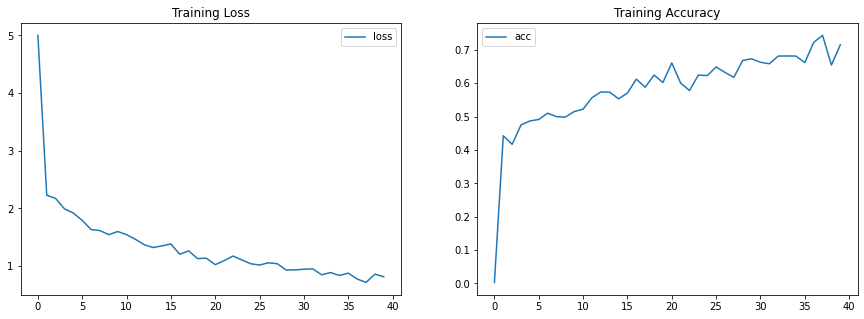

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

### Inference
To restore the lastest checkpoint, saved model, you can run the following cell:

In [22]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In the prediction step, our input is a sequence of length one, the ``sos`` token, then we call the encoder and ``decoder`` repeatedly until we get the eos token or reach the maximum length defined.

In [23]:
def predict(
    input_text, encoder, 
    input_max_len, tokenizer_inputs, 
    word2idx_outputs, idx2word_outputs
  ):
  if input_text is None:
    input_text = input_data[np.random.choice(len(input_data))]
    # Tokenize the input text  
  input_seq = tokenizer_inputs.texts_to_sequences([input_text])
  # Pad the input sentence
  input_seq = pad_sequences(input_seq, maxlen=input_max_len,
                            padding='post')         
  en_initial_states = encoder.init_states(1)      
  en_outputs = encoder(tf.constant(input_seq), en_initial_states)
  de_input = tf.constant([[word2idx_outputs['<sos>']]]) 
  de_state_h, de_state_c = en_outputs[1:]
  out_words = []
  while True:
    de_output, de_state_h, de_state_c = decoder(
          de_input, (de_state_h, de_state_c))    
    de_input = tf.argmax(de_output, -1)
    out_words.append(idx2word_outputs[de_input.numpy()[0][0]])

    if out_words[-1] == '<eos>' or len(out_words) >= 80:
        break     
  return ' '.join(out_words)

In [24]:

for inp, trg in zip(input_data[1200: 1210], target_data[1200: 1210]):
  predicted = predict(inp, encoder, input_max_len, tokenizer_inputs,
                      word2idx_outputs, idx2word_outputs)
  print("> input: ", inp)
  print("< predicted:", predicted)
  print("< real trg:", trg)
  print()
  print('*' * 100)
  print() 

> input:  el salio a comer .
< predicted: he went to bed . <eos>
< real trg: he ate out . <eos>

****************************************************************************************************

> input:  el se rindio .
< predicted: he seems hungry . <eos>
< real trg: he gave in . <eos>

****************************************************************************************************

> input:  se rindio .
< predicted: i ll be glad to . <eos>
< real trg: he gave up . <eos>

****************************************************************************************************

> input:  lo dejo .
< predicted: i ll reward you . <eos>
< real trg: he gave up . <eos>

****************************************************************************************************

> input:  cedio .
< predicted: it gets better . <eos>
< real trg: he gave up . <eos>

****************************************************************************************************

> input:  tiro la toalla .
< pred

### Conclusion
In the next Notebook we are going to clone this notebook and have a look at the Encoder Decoder Model with attention. The data processing and preparation will remain the same, We are only going to change the model achitecture.
